In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Path to your features
npz_path = '/content/drive/MyDrive/Speech_Emotion_Recognition/features.npz'

# Load the dataset
data = np.load(npz_path)
X = data['features']
y = data['labels']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)  # One-hot encode for classification

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Expand dims if needed (e.g., ResNet expects 4D input)
if len(X_train.shape) == 3:
    X_train = np.expand_dims(X_train, -1)
    X_test = np.expand_dims(X_test, -1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (12736, 128, 216, 1)
y_train shape: (12736, 10)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

# Define input shape from training data
input_shape = X_train.shape[1:]  # Usually (time, features, 1)

# Build the CNN model
model = models.Sequential([
    # Input layer
    layers.Input(shape=input_shape),

    # Conv Block 1
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Global Pooling instead of Flatten (reduces overfitting)
    layers.GlobalAveragePooling2D(),

    # Dense Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(y_train.shape[1], activation='softmax')  # # of emotion classes
])


In [ ]:
# Print model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 216, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # optional label smoothing
    metrics=['accuracy']
)


In [8]:
 early_stop = callbacks.EarlyStopping(
     monitor='val_loss',
     patience=5,
     restore_best_weights=True
 )


In [9]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # 20% of training set used for validation
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.3180 - loss: 1.9061 - val_accuracy: 0.3265 - val_loss: 1.7911
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.5380 - loss: 1.4799 - val_accuracy: 0.4505 - val_loss: 1.6332
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6098 - loss: 1.3399 - val_accuracy: 0.4678 - val_loss: 1.6643
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6440 - loss: 1.2714 - val_accuracy: 0.5989 - val_loss: 1.3474
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6578 - loss: 1.2465 - val_accuracy: 0.5734 - val_loss: 1.4628
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6882 - loss: 1.1881 - val_accuracy: 0.6213 - val_loss: 1.3176
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6980 - loss: 1.1671 - val_accuracy: 0.6162 - val_loss: 1.3278
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7157 - loss: 1.1315 - v

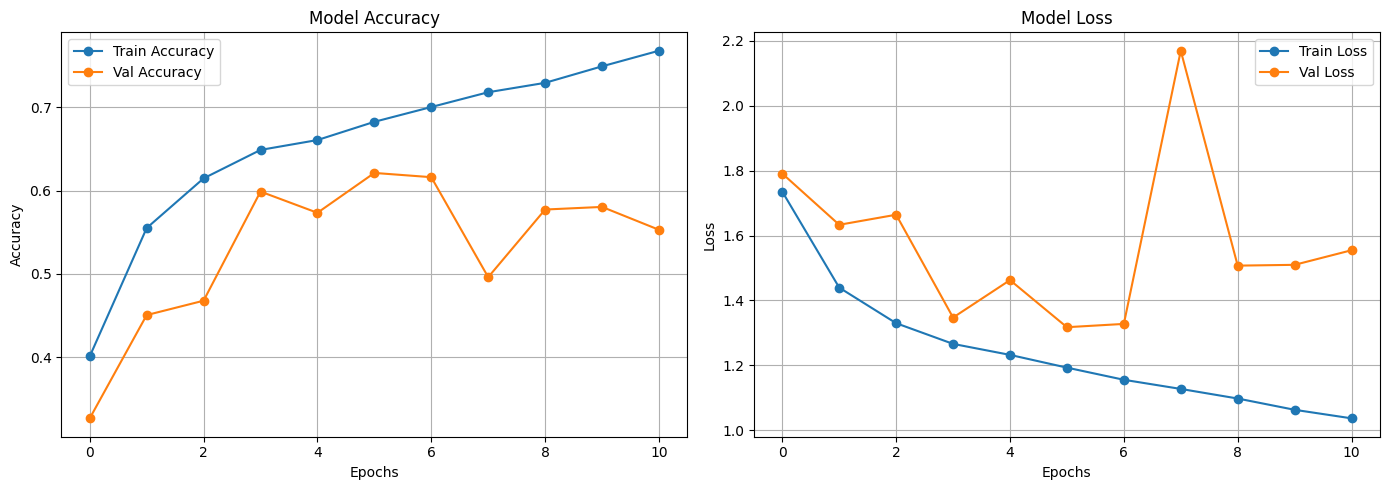

In [10]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6122 - loss: 1.3123
Test Accuracy: 61.48%


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       491
           1       0.85      0.22      0.35        77
           2       0.56      0.63      0.59       491
           3       1.00      1.00      1.00       160
           4       0.44      0.17      0.25       331
           5       0.43      0.75      0.54       491
           6       0.87      0.54      0.66       416
           7       1.00      0.98      0.99       160
           8       0.81      0.47      0.60       491
           9       0.31      0.88      0.46        77

    accuracy                           0.61      3185
   macro avg       0.69      0.64      0.62      3185
weighted avg       0.67      0.61      0.61      3185



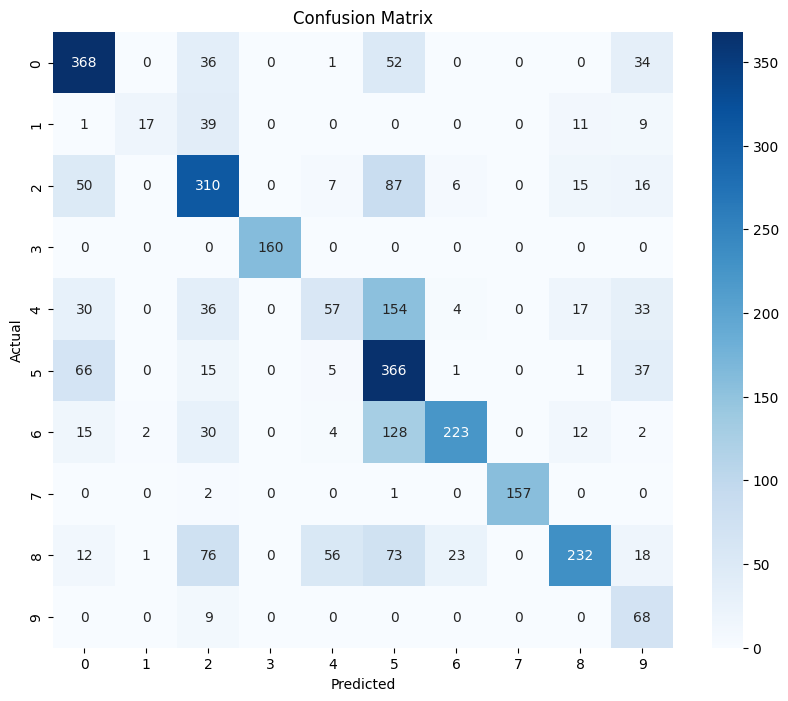

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
